## Consider which FQDNs to take into account in this study
There's a difference in citation counts for each FQDN, so I need to consider which FQDNs to take into account

In [10]:
import pandas as pd 
import numpy as np 
import ast

In [11]:
data = pd.read_csv("../data/processed/notes_2024_fqdn.csv")
data.head(2)

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"['www.newsweek.com', 'pbs.twimg.com', 'truthso...","['www.newsweek.com', 'www.pbs.org', 'truthsoci..."
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"['www.factcheck.org', 'www.reuters.com', 'apne...","['www.factcheck.org', 'www.reuters.com', 'apne..."


In [12]:
data["fqdn_replaced"] = data["fqdn_replaced"].apply(ast.literal_eval)
data["fqdn"] = data["fqdn"].apply(ast.literal_eval)

In [13]:
from collections import Counter

all_domains = [domain for sublist in data["fqdn_replaced"] for domain in sublist]

# count the occurrences of each domain
domain_counts = Counter(all_domains)

# sort the counts and convert to DataFrame
df_counts = pd.DataFrame(domain_counts.items(), columns=["domain", "count"]).sort_values(by="count", ascending=False).reset_index(drop=True)

df_counts.head(3)

,domain,count
0,x.com,1050
1,en.m.wikipedia.org,299
2,www.youtube.com,278


Calculating best minimal value for power law fit
estimated xmin: 2.0
estimated alpha: 2.0797455922169883
Loglikelihood ratio R: 0.0679273494871262
p-value: 0.010987757095722592
Loglikelihood ratio R: 418.0623667009996
p-value: 1.1699506168909878e-09


/opt/anaconda3/lib/python3.12/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


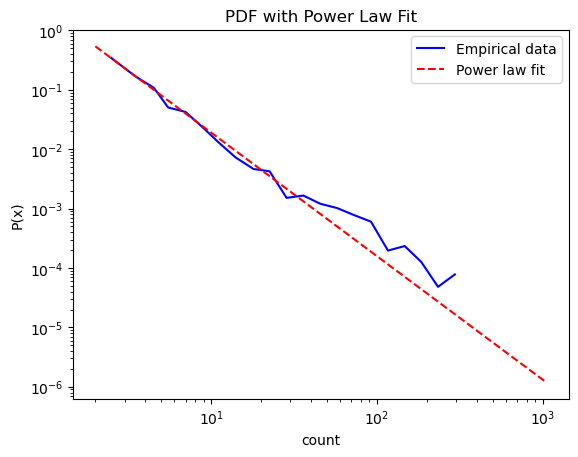

In [14]:
import powerlaw
import matplotlib.pyplot as plt

# check if the data is suitable for power law fitting
df_counts["count"]


# fit the power law model
fit = powerlaw.Fit(df_counts["count"])

# summarize the fit
print(f"estimated xmin: {fit.xmin}")
print(f"estimated alpha: {fit.alpha}")

R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Loglikelihood ratio R: {R}")
print(f"p-value: {p}")

R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Loglikelihood ratio R: {R}")
print(f"p-value: {p}")

# visualize the fit
fig = fit.plot_pdf(label='Empirical data', color='b')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='Power law fit')
plt.legend()
plt.xlabel("count")
plt.ylabel("P(x)")
plt.title("PDF with Power Law Fit")
plt.show()


This data statistically significantly follows power law (count > 2). However, to calculate both media bias scores and helpful scores, citation count is only 2 is likely to causes noise (e.g. when calculating confidence intervals)


In [15]:
cumsum = df_counts["count"].cumsum()
total = df_counts["count"].sum()
threshold = total * 0.65

for i, value in enumerate(cumsum):
    if value >= threshold:
        print(f"when exceeds 65%?: {df_counts.loc[i, "domain"]}, {df_counts.loc[i, "count"]}")
        print(f"culmative value: {value}")
        break

when exceeds 80%?: www.donaldjtrump.com, 32
culmative value: 4393


In [17]:
df_selected = df_counts[df_counts["count"] >= 32]
media_list = df_selected["domain"]

## this data is the filtered by media_list

data['fqdn_selected'] = data['fqdn_replaced'].apply(lambda x: [i for i in x if i in media_list.tolist()])

data.head(2)

,summary,currentStatus,createdAtMillis,datetime,fqdn,fqdn_replaced,fqdn_selected
0,Trump posted on Truth Social on 12/30/2023 tha...,CURRENTLY_RATED_HELPFUL,1704054854654,2024-01-01,"[www.newsweek.com, pbs.twimg.com, truthsocial....","[www.newsweek.com, www.pbs.org, truthsocial.com]","[www.newsweek.com, www.pbs.org, truthsocial.com]"
1,This has been refuted multiple times as false....,CURRENTLY_RATED_HELPFUL,1704090450017,2024-01-01,"[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]","[www.factcheck.org, www.reuters.com, apnews.com]"


In [19]:
data.to_csv("../data/processed/notes_2024_fqdn_selected.csv", index=False)